In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
import datetime
import re
from nltk.corpus import stopwords
import nltk
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

conn = sqlite3.connect(r"../../diplom.db")
cur = conn.cursor()

In [2]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from NG;""").fetchall()]
graph = [i[0] for text in corpus for i in nltk.bigrams(text) if i[1] == "демократия"]
c = Counter(graph)
adjusting = pd.DataFrame(c.most_common()).rename(columns={0: "Слово", 1: "Количество"})
adjusting["Часть"] = [i[1] for i in nltk.pos_tag(adjusting["Слово"], lang="rus")]
adj = adjusting[adjusting["Часть"].isin(["A=m", "A-PRO=m"])].reset_index(drop=True)
s = adj["Количество"].sum()
adj["Процент"] = round(adj["Количество"]/s*100, 2)

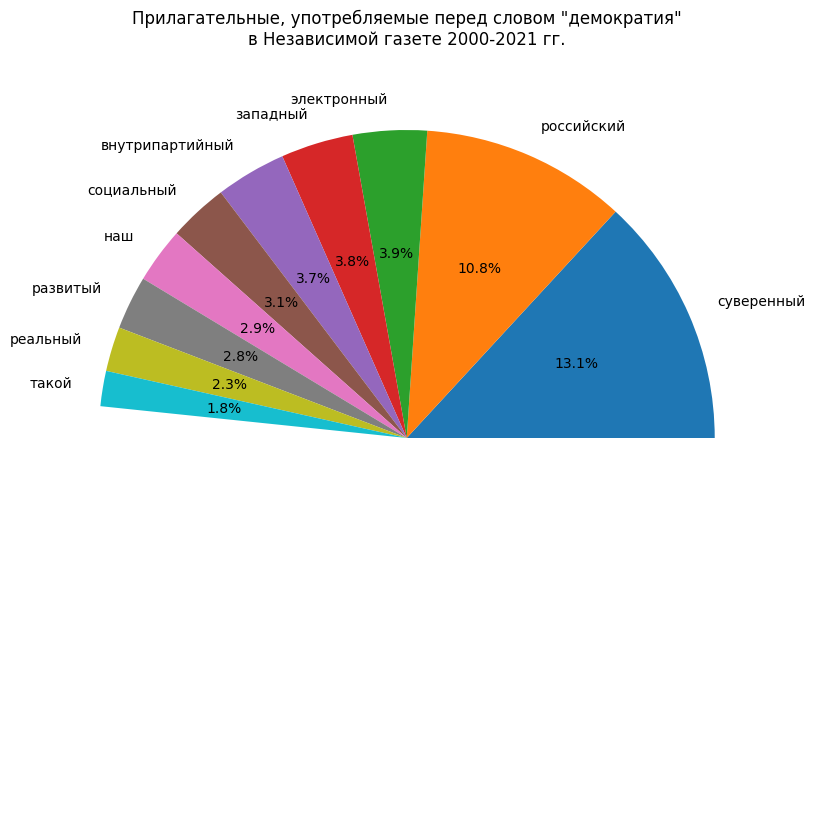

In [3]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
rus = adj[["Слово", "Процент"]].head(10)
rus.loc[10, "Слово"] = "Ост."
rus.loc[10, "Процент"] = adj.loc[10:, "Процент"].sum()
wedge, text, procent = ax.pie(rus["Процент"], labels=rus["Слово"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Прилагательные, употребляемые перед словом "демократия"\nв Независимой газете 2000-2021 гг.')
fig.savefig("ng_adj_ru.png")

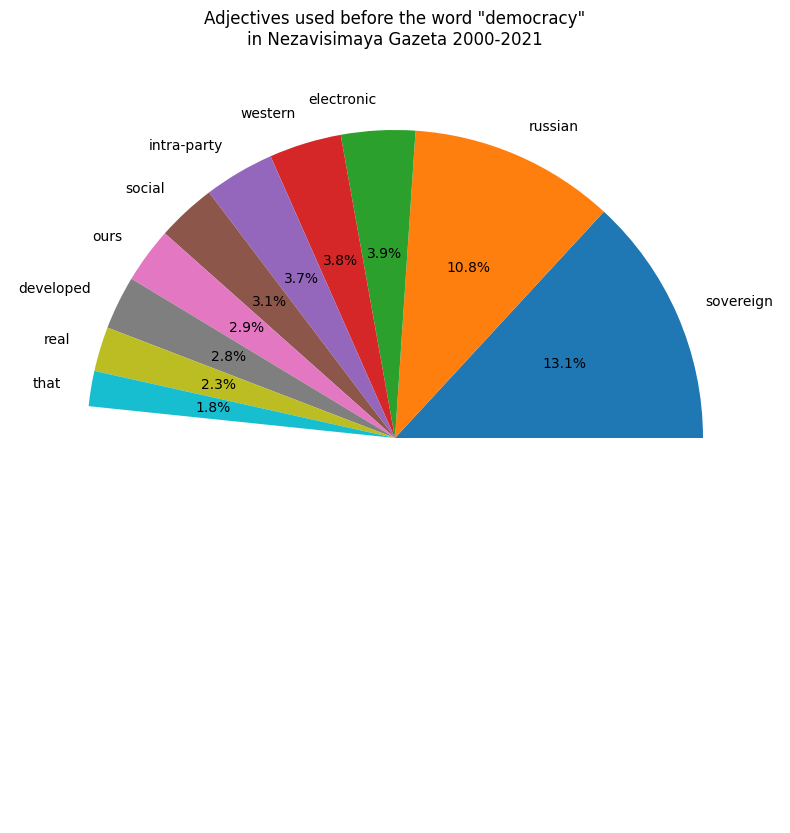

In [4]:
eng = rus.copy()
eng['Word'] = ['sovereign', 'russian', 'electronic', 'western', 'intra-party', 'social', 'ours', 'developed', 'real', 'that', 'rest']
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True)
wedge, text, procent = ax.pie(rus["Процент"], labels=eng["Word"], autopct='%1.1f%%')
wedge[10].set_visible(False)
text[10].set_visible(False)
procent[10].set_visible(False)
ax.set_title('Adjectives used before the word "democracy"\nin Nezavisimaya Gazeta 2000-2021')
fig.savefig("ng_adj_en.png")

In [4]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from NG""").fetchall()]
model = Word2Vec(corpus, 
                 vector_size=1024,      # embedding vector size
                 min_count=2,
                 window=5).wv
model.save("ng.model")
model.most_similar('демократия')

[('многопартийность', 0.597098171710968),
 ('авторитаризм', 0.5659778118133545),
 ('парламентаризм', 0.5609177350997925),
 ('государственность', 0.5491819977760315),
 ('демократический', 0.5337891578674316),
 ('федерализм', 0.5318149328231812),
 ('консерватизм', 0.5265754461288452),
 ('либерализм', 0.5210914015769958),
 ('народовластие', 0.5191507935523987),
 ('суверенный', 0.5140568614006042)]

In [5]:
model = Word2Vec.load("ng.model")

In [6]:
model

In [8]:
kv = model.wv

In [10]:
kv.vectors.shape

(65853, 1024)

In [13]:
from sklearn.cluster import KMeans

In [12]:
!python3 -m pip install -U scikit-learn

  Using cached scikit_learn-1.3.2-cp38-cp38-macosx_10_9_x86_64.whl (10.1 MB)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3 -m pip install --upgrade pip' command.


In [15]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(kv.vectors)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [17]:
kmeans.cluster_centers_

array([[ 0.04396654, -0.05486162,  0.03100079, ...,  0.0092327 ,
         0.12317234,  0.11282916],
       [ 0.08933784,  0.1167127 , -0.15646729, ..., -0.16152477,
         0.12113356, -0.12676355],
       [ 0.01039145, -0.01106228,  0.01096173, ..., -0.01112559,
        -0.00033457, -0.00138807],
       [ 0.12183952,  0.2395754 ,  0.22102661, ...,  0.07509403,
        -0.07585537, -0.18889181],
       [-0.10267933, -0.01071968,  0.12299485, ..., -0.01338926,
        -0.15831023,  0.04461379]], dtype=float32)

In [18]:
kmeans.labels_

array([2, 1, 1, ..., 2, 2, 2], dtype=int32)

In [19]:
from sklearn.metrics import silhouette_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [34]:
corpus = [text[0].split() for text in cur.execute("""select CLEAN_TEXT from NG WHERE DEMOCRACY_COUNT>0""").fetchall()]

In [35]:
tmp = [' '.join(i) for i in corpus]

In [36]:
len(tmp)

2067

In [37]:
vec = TfidfVectorizer()
X = vec.fit_transform(tmp)

In [38]:
pca = TruncatedSVD(n_components=2)
X_pca = pca.fit_transform(X)

In [43]:
kmeans = KMeans(n_clusters=2)
kmeans_clusters = kmeans.fit_predict(X_pca)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


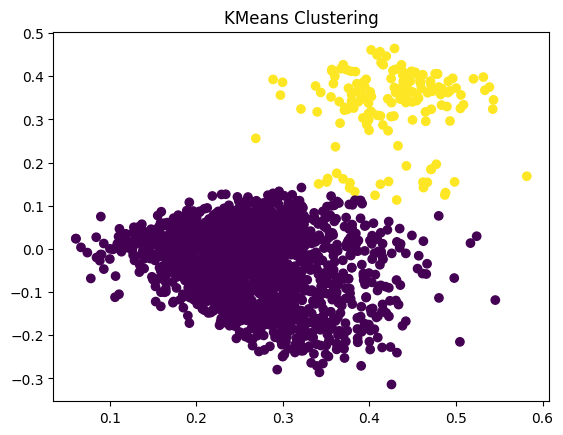

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_clusters, cmap='viridis')
plt.title('KMeans Clustering')
plt.show()

In [48]:
tfidf_matrix = vec.fit_transform(tmp)

# Получение списка ключевых слов и их значения TF-IDF для первого документа
feature_names = vec.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray()[0]

# Сортировка слов по значениям TF-IDF
sorted_keywords = [word for _, word in sorted(zip(tfidf_scores, feature_names), reverse=True)]

print("Ключевые слова:", sorted_keywords)

Ключевые слова: ['паспорт', 'загранпаспорт', 'украина', 'выдавать', 'фмс', 'иск', 'рф', 'суд', 'литва', 'выдача', 'мид', 'крым', 'ошибка', 'территория', 'электронный', 'линкявичюс', 'документ', 'проездной', 'рождение', 'скомпрометировать', 'единичный', 'дата', 'признавать', 'въезжать', 'аннексия', 'это', 'основание', 'недействительный', 'орган', 'украинский', 'заграничный', 'удостоверение', 'нахождение', 'личность', 'калининградский', 'исаев', 'миграционный', 'регистрировать', 'право', 'украинец', 'резонанс', 'заведомо', 'международный', 'история', 'трактовать', 'служба', 'россия', 'соответствующий', 'дипломатический', 'российский', 'действительность', 'пиар', 'государство', 'фльонц', 'пшик', 'медиавброс', 'жилин', 'госпогранслужба', 'обратный', 'отказывать', 'причем', 'война', 'гражданин', 'юст', 'уфмс', 'удостоверять', 'минкульт', 'конфузный', 'должный', 'который', 'обычный', 'хронология', 'общегражданский', 'юридический', 'запрет', 'другой', 'тарасенко', 'приравниваться', 'подставля

In [52]:
from gensim import corpora
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

In [53]:
documents = ["Текст документа 1", "Текст документа 2"]
stop_words = set(STOPWORDS)
texts = [[word for word in simple_preprocess(doc) if word not in stop_words] for doc in documents]


In [57]:
dictionary = corpora.Dictionary(corpus)
doc_corpus = [dictionary.doc2bow(text) for text in corpus]

In [65]:
num_topics = 10
lda_model = LdaModel(doc_corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Вывод тем и связанных с ними слов
for idx, topic in lda_model.print_topics(-1):
    print(f"Тема {idx + 1}: {topic}")

Тема 1: 0.019*"это" + 0.013*"который" + 0.011*"-" + 0.009*"человек" + 0.007*"год" + 0.007*"говорить" + 0.006*"этот" + 0.006*"такой" + 0.006*"путин" + 0.005*"наш"
Тема 2: 0.010*"россия" + 0.010*"президент" + 0.008*"который" + 0.008*"государство" + 0.007*"страна" + 0.007*"медведев" + 0.007*"политический" + 0.007*"общественный" + 0.007*"-" + 0.007*"демократия"
Тема 3: 0.022*"партия" + 0.017*"выборы" + 0.013*"-" + 0.008*"который" + 0.008*"кандидат" + 0.008*"яблоко" + 0.007*"нга" + 0.007*"политический" + 0.006*"человек" + 0.006*"это"
Тема 4: 0.026*"-" + 0.016*"е" + 0.012*"бунтман" + 0.012*"2" + 0.008*"1" + 0.008*"3" + 0.005*"0" + 0.005*"4" + 0.003*"самсонов" + 0.003*"год"
Тема 5: 0.026*"это" + 0.016*"который" + 0.014*"человек" + 0.013*"говорить" + 0.011*"ремчук" + 0.008*"этот" + 0.006*"такой" + 0.006*"-" + 0.006*"какой-то" + 0.006*"поэтому"
Тема 6: 0.022*"россия" + 0.011*"российский" + 0.010*"-" + 0.007*"вопрос" + 0.007*"ес" + 0.007*"президент" + 0.006*"право" + 0.006*"сша" + 0.005*"москва"

In [66]:
lda_model.show_topics(10)

[(0,
  '0.019*"это" + 0.013*"который" + 0.011*"-" + 0.009*"человек" + 0.007*"год" + 0.007*"говорить" + 0.006*"этот" + 0.006*"такой" + 0.006*"путин" + 0.005*"наш"'),
 (1,
  '0.010*"россия" + 0.010*"президент" + 0.008*"который" + 0.008*"государство" + 0.007*"страна" + 0.007*"медведев" + 0.007*"политический" + 0.007*"общественный" + 0.007*"-" + 0.007*"демократия"'),
 (2,
  '0.022*"партия" + 0.017*"выборы" + 0.013*"-" + 0.008*"который" + 0.008*"кандидат" + 0.008*"яблоко" + 0.007*"нга" + 0.007*"политический" + 0.006*"человек" + 0.006*"это"'),
 (3,
  '0.026*"-" + 0.016*"е" + 0.012*"бунтман" + 0.012*"2" + 0.008*"1" + 0.008*"3" + 0.005*"0" + 0.005*"4" + 0.003*"самсонов" + 0.003*"год"'),
 (4,
  '0.026*"это" + 0.016*"который" + 0.014*"человек" + 0.013*"говорить" + 0.011*"ремчук" + 0.008*"этот" + 0.006*"такой" + 0.006*"-" + 0.006*"какой-то" + 0.006*"поэтому"'),
 (5,
  '0.022*"россия" + 0.011*"российский" + 0.010*"-" + 0.007*"вопрос" + 0.007*"ес" + 0.007*"президент" + 0.006*"право" + 0.006*"сша" +